In [ ]:
pip install omdet

In [ ]:
import os, json, time, gc
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torchvision.ops import nms
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

# 🔹 Parámetros globales para comparación justa entre modelos
PARAMS = {
    # Conjunto de imágenes
    "max_images": 50,          # Número máximo de imágenes a procesar
    # Umbrales y filtros
    "score_thr": 0.3,          # Umbral de score mínimo para considerar detecciones
    "nms_iou": 0.5,            # IoU para supresión de solapamiento (NMS)
    "min_box_side": 12,        # Tamaño mínimo de lado de caja para filtrar detecciones
    "topk_label": 40,          # Top-K detecciones por clase
    # Visualización
    "score_min_draw": 0.2,     # Umbral mínimo para mostrar en plots
    "max_draw": 25,          # Máximo de cajas a dibujar por imagen
}

### DINO

loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
870 imágenes con al menos un vehículo encontradas.


Procesando imágenes: 100%|██████████| 870/870 [05:29<00:00,  2.64it/s]


Resultados guardados: 5146 detecciones
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.21s).
Accumulating evaluation results...
DONE (t=0.26s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.595
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.642
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.530
 Average Recall     (AR) @[ I

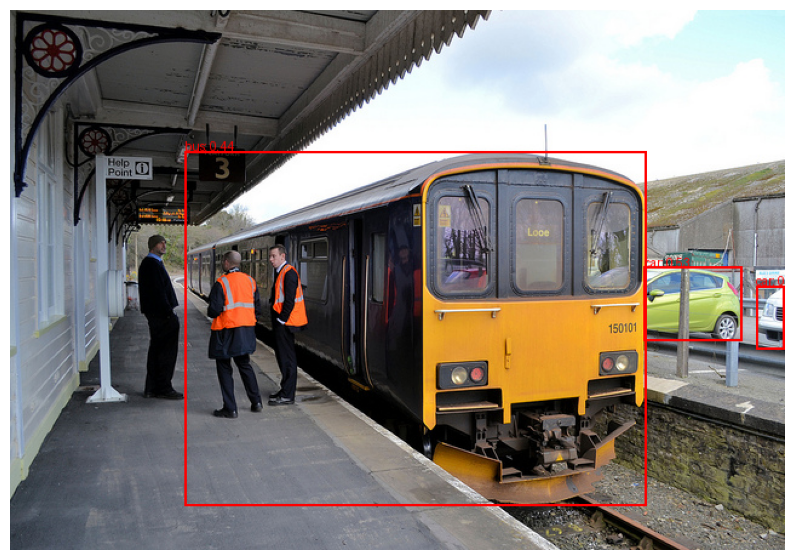

In [33]:
# ==============================
# Grounding DINO Tiny en COCO val2017 (vehículos) con thresholds bajos
# ==============================

import os
import torch
import json
from tqdm import tqdm
from PIL import Image, ImageDraw
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# ----- 1️⃣ COCO dataset -----
dataDir = "./COCO"
dataType = "val2017"
annFile = os.path.join(dataDir, "annotations", f"instances_{dataType}.json")
coco_gt = COCO(annFile)

vehicle_classes = ['car', 'bus', 'truck', 'bicycle', 'motorcycle']
cat_ids = coco_gt.getCatIds(catNms=vehicle_classes)

# Obtener todas las imágenes que tengan al menos una categoría de vehículo
img_ids_set = set()
for cat_id in cat_ids:
    ids = coco_gt.getImgIds(catIds=[cat_id])
    img_ids_set.update(ids)

img_ids = list(img_ids_set)
images = coco_gt.loadImgs(img_ids)

print(f"{len(images)} imágenes con al menos un vehículo encontradas.")

# ----- 2️⃣ Cargar Grounding DINO -----
model_id = "IDEA-Research/grounding-dino-tiny"
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(
    model_id).to(device)
model.eval()

# ----- 3️⃣ Inferencia y conversión a formato COCO -----
coco_results = []

for img in tqdm(images, desc="Procesando imágenes"):
    img_path = os.path.join(dataDir, "images", dataType, img['file_name'])
    image = Image.open(img_path).convert("RGB")
    width, height = image.size

    # Pasamos directamente la lista de clases
    inputs = processor(
        images=image,
        text=vehicle_classes,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(
            pixel_values=inputs.pixel_values,
            input_ids=inputs.input_ids
        )

    # Postprocesar con thresholds bajos
    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        threshold=0.25,     # box confidence bajo
        text_threshold=0.25,  # text similarity bajo
        target_sizes=[(height, width)]
    )[0]

    # Dibujar detecciones y guardar en formato COCO
    draw = ImageDraw.Draw(image)
    for box, score, label_text in zip(results["boxes"], results["scores"], results["labels"]):
        label_clean = label_text.lower()  # ya es string
        if label_clean in vehicle_classes:
            x1, y1, x2, y2 = box.tolist()
            coco_results.append({
                "image_id": img['id'],
                "category_id": coco_gt.getCatIds(catNms=[label_clean])[0],
                "bbox": [x1, y1, x2-x1, y2-y1],
                "score": float(score)
            })

            # Dibujar en la imagen
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            draw.text((x1, y1-10), f"{label_clean}: {score:.2f}", fill="red")


# ----- 4️⃣ Guardar resultados -----
with open("grounding_dino_tiny_highrec.json", "w") as f:
    json.dump(coco_results, f)

print(f"Resultados guardados: {len(coco_results)} detecciones")

# ----- 5️⃣ Evaluación COCO -----
if len(coco_results) > 0:
    coco_dt = coco_gt.loadRes("grounding_dino_tiny_highrec.json")
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.params.catIds = cat_ids
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
else:
    print("No se detectaron objetos, ajusta thresholds o prompt.")

# Mostrar última imagen procesada en notebook
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis("off")
plt.show()

loading annotations into memory...
Done (t=0.79s)
creating index...
index created!
870 imágenes con al menos un vehículo encontradas.


Procesando imágenes: 100%|██████████| 870/870 [07:17<00:00,  1.99it/s]


Resultados guardados: 4890 detecciones
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.24s).
Accumulating evaluation results...
DONE (t=0.26s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.558
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.743
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.596
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.613
 Average Recall     (AR) @[ I

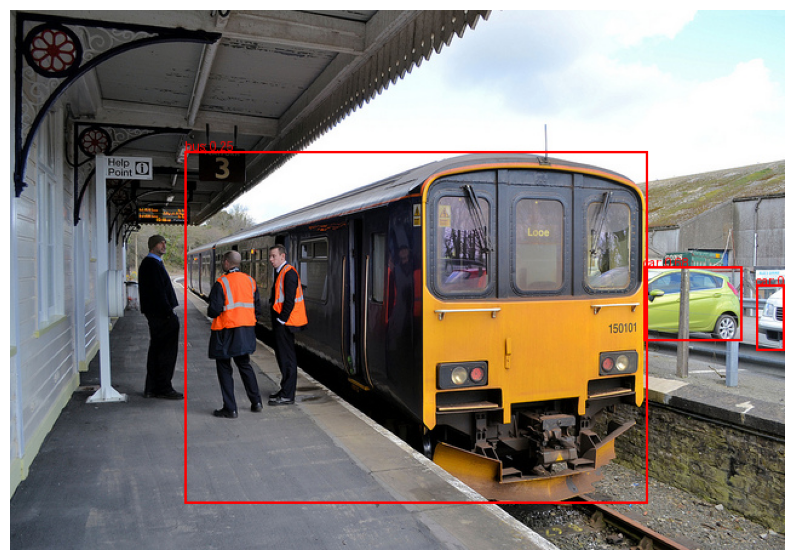

In [34]:
# ==============================
# Grounding DINO Base en COCO val2017 (vehículos) con thresholds bajos
# ==============================

import os
import torch
import json
from tqdm import tqdm
from PIL import Image, ImageDraw
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# ----- 1️⃣ COCO dataset -----
dataDir = "./COCO"
dataType = "val2017"
annFile = os.path.join(dataDir, "annotations", f"instances_{dataType}.json")
coco_gt = COCO(annFile)

vehicle_classes = ['car', 'bus', 'truck', 'bicycle', 'motorcycle']
cat_ids = coco_gt.getCatIds(catNms=vehicle_classes)

# Obtener todas las imágenes que tengan al menos una categoría de vehículo
img_ids_set = set()
for cat_id in cat_ids:
    ids = coco_gt.getImgIds(catIds=[cat_id])
    img_ids_set.update(ids)

img_ids = list(img_ids_set)
images = coco_gt.loadImgs(img_ids)

print(f"{len(images)} imágenes con al menos un vehículo encontradas.")

# ----- 2️⃣ Cargar Grounding DINO -----
model_id = "IDEA-Research/grounding-dino-base"
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(
    model_id).to(device)
model.eval()

# ----- 3️⃣ Inferencia y conversión a formato COCO -----
coco_results = []

for img in tqdm(images, desc="Procesando imágenes"):
    img_path = os.path.join(dataDir, "images", dataType, img['file_name'])
    image = Image.open(img_path).convert("RGB")
    width, height = image.size

    # Pasamos directamente la lista de clases
    inputs = processor(
        images=image,
        text=vehicle_classes,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(
            pixel_values=inputs.pixel_values,
            input_ids=inputs.input_ids
        )

    # Postprocesar con thresholds bajos
    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        threshold=0.25,     # box confidence bajo
        text_threshold=0.25,  # text similarity bajo
        target_sizes=[(height, width)]
    )[0]

    # Dibujar detecciones y guardar en formato COCO
    draw = ImageDraw.Draw(image)
    for box, score, label_text in zip(results["boxes"], results["scores"], results["labels"]):
        label_clean = label_text.lower()  # ya es string
        if label_clean in vehicle_classes:
            x1, y1, x2, y2 = box.tolist()
            coco_results.append({
                "image_id": img['id'],
                "category_id": coco_gt.getCatIds(catNms=[label_clean])[0],
                "bbox": [x1, y1, x2-x1, y2-y1],
                "score": float(score)
            })

            # Dibujar en la imagen
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            draw.text((x1, y1-10), f"{label_clean}: {score:.2f}", fill="red")


# ----- 4️⃣ Guardar resultados -----
with open("grounding_dino_base_highrec.json", "w") as f:
    json.dump(coco_results, f)

print(f"Resultados guardados: {len(coco_results)} detecciones")

# ----- 5️⃣ Evaluación COCO -----
if len(coco_results) > 0:
    coco_dt = coco_gt.loadRes("grounding_dino_base_highrec.json")
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.params.catIds = cat_ids
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
else:
    print("No se detectaron objetos, ajusta thresholds o prompt.")

# Mostrar última imagen procesada en notebook
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis("off")
plt.show()

### OMDET

loading annotations into memory...
Done (t=0.51s)
creating index...
index created!
870 imágenes con al menos un vehículo encontradas.


Procesando imágenes: 100%|██████████| 870/870 [01:08<00:00, 12.64it/s]


Resultados guardados: 4865 detecciones
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.29s).
Accumulating evaluation results...
DONE (t=0.24s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.418
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.669
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.512
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.518
 Average Recall     (AR) @[ I

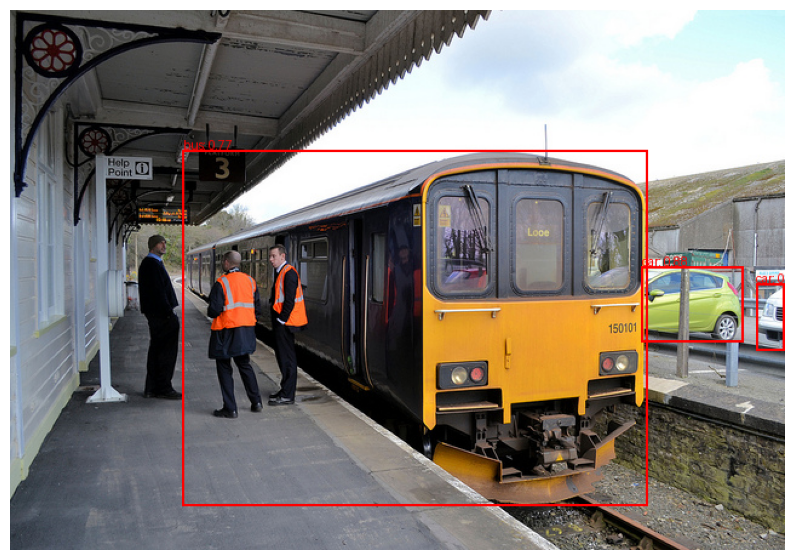

In [26]:
# ==============================
# OmDet-Turbo en COCO val2017 (vehículos)
# ==============================

import os
import torch
import json
from tqdm import tqdm
from PIL import Image, ImageDraw
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from transformers import AutoProcessor, OmDetTurboForObjectDetection

device = "cuda" if torch.cuda.is_available() else "cpu"

# ----- 1️⃣ COCO dataset -----
dataDir = "./COCO"
dataType = "val2017"
annFile = os.path.join(dataDir, "annotations", f"instances_{dataType}.json")
coco_gt = COCO(annFile)

vehicle_classes = ['car', 'bus', 'truck', 'bicycle', 'motorcycle']
cat_ids = coco_gt.getCatIds(catNms=vehicle_classes)

# Filtramos imágenes con vehículos
img_ids_set = set()
for cat_id in cat_ids:
    ids = coco_gt.getImgIds(catIds=[cat_id])
    img_ids_set.update(ids)

img_ids = list(img_ids_set)
images = coco_gt.loadImgs(img_ids)

print(f"{len(images)} imágenes con al menos un vehículo encontradas.")

# ----- 2️⃣ Cargar OmDet-Turbo -----
model_id = "omlab/omdet-turbo-swin-tiny-hf"
processor = AutoProcessor.from_pretrained(model_id)
model = OmDetTurboForObjectDetection.from_pretrained(model_id).to(device)
model.eval()

# ----- 3️⃣ Inferencia y conversión a formato COCO -----
coco_results = []

# Puedes limitar para pruebas rápidas
# for img in tqdm(images[:50], desc="Procesando imágenes"):
for img in tqdm(images, desc="Procesando imágenes"):
    img_path = os.path.join(dataDir, "images", dataType, img['file_name'])
    image = Image.open(img_path).convert("RGB")
    width, height = image.size

    # 👈 Aquí pasamos imagen + clases
    inputs = processor(images=image, text=vehicle_classes,
                       return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    # 👈 Postproceso correcto para OmDet
    results = processor.post_process_grounded_object_detection(
        outputs,
        vehicle_classes,   # 👈 directamente la lista de clases
        threshold=0.25,
        target_sizes=[(height, width)]
    )[0]

    # Dibujar detecciones y guardar en formato COCO
    draw = ImageDraw.Draw(image)
    for box, score, label_id in zip(results["boxes"], results["scores"], results["labels"]):
        # Convierte tensor -> int
        label_id = int(label_id.item()) if hasattr(label_id, "item") else int(label_id)
        # Mapea al nombre de clase
        label_clean = vehicle_classes[label_id]
    
        if label_clean in vehicle_classes:
            x1, y1, x2, y2 = box.tolist()
            coco_results.append({
                "image_id": img['id'],
                "category_id": coco_gt.getCatIds(catNms=[label_clean])[0],
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "score": float(score)
            })
            # Opcional: dibujar
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            draw.text((x1, y1 - 10), f"{label_clean}: {score:.2f}", fill="red")


# ----- 4️⃣ Guardar resultados -----
with open("omdet_turbo_coco_results.json", "w") as f:
    json.dump(coco_results, f)

print(f"Resultados guardados: {len(coco_results)} detecciones")

# ----- 5️⃣ Evaluación COCO -----
if len(coco_results) > 0:
    coco_dt = coco_gt.loadRes("omdet_turbo_coco_results.json")
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.params.catIds = cat_ids  # Solo vehículos
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
else:
    print("No se detectaron objetos, ajusta thresholds.")
    
# Mostrar en notebook
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis("off")
plt.show()

### OWLv2

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
870 imágenes con al menos un vehículo encontradas.


Procesando imágenes:   0%|          | 0/870 [00:00<?, ?it/s]c:\Users\Tito\anaconda3\envs\dino\lib\site-packages\transformers\models\owlv2\processing_owlv2.py:201: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(
Procesando imágenes: 100%|██████████| 870/870 [06:17<00:00,  2.31it/s]


Resultados guardados: 3958 detecciones
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.14s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.394
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.623
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.414
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.400
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.578
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.487
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.502
 Average Recall     (AR) @[ I

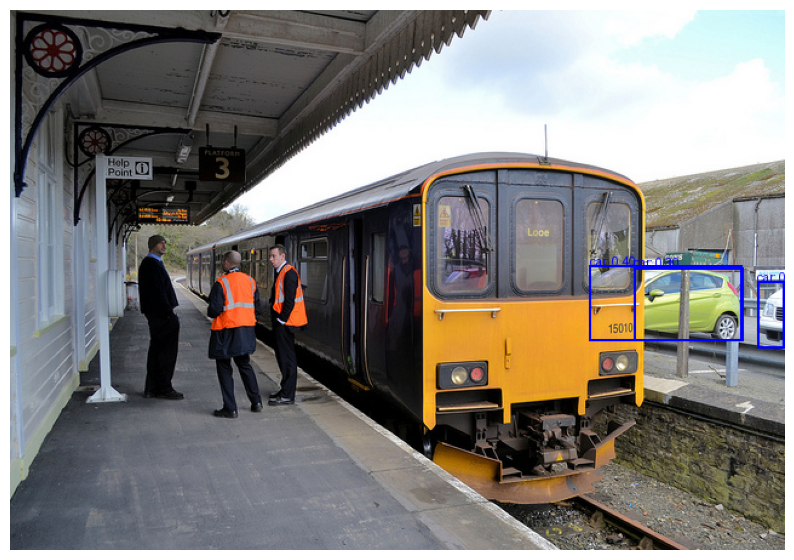

In [28]:
# ==============================
# OWLv2 en COCO val2017 (vehículos)
# ==============================

import os
import torch
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from transformers import AutoProcessor, Owlv2ForObjectDetection

device = "cuda" if torch.cuda.is_available() else "cpu"

# ----- 1️⃣ COCO dataset -----
dataDir = "./COCO"
dataType = "val2017"
annFile = os.path.join(dataDir, "annotations", f"instances_{dataType}.json")
coco_gt = COCO(annFile)

vehicle_classes = ['car', 'bus', 'truck', 'bicycle', 'motorcycle']
cat_ids = coco_gt.getCatIds(catNms=vehicle_classes)

# Filtramos imágenes con vehículos
img_ids_set = set()
for cat_id in cat_ids:
    ids = coco_gt.getImgIds(catIds=[cat_id])
    img_ids_set.update(ids)

img_ids = list(img_ids_set)
images = coco_gt.loadImgs(img_ids)

print(f"{len(images)} imágenes con al menos un vehículo encontradas.")

# ----- 2️⃣ Cargar OWLv2 -----
MODEL_ID = "google/owlv2-base-patch16-ensemble"
processor = AutoProcessor.from_pretrained(MODEL_ID)
model = Owlv2ForObjectDetection.from_pretrained(MODEL_ID).to(device)
model.eval()

# ----- 3️⃣ Inferencia y conversión a formato COCO -----
coco_results = []

# ⚡ prueba con pocas imágenes si quieres: images[:50]
for img in tqdm(images, desc="Procesando imágenes"):
    img_path = os.path.join(dataDir, "images", dataType, img['file_name'])
    image = Image.open(img_path).convert("RGB")
    width, height = image.size

    # 👈 OWLv2 espera lista de listas (prompts agrupados por imagen)
    texts = [vehicle_classes]

    inputs = processor(text=texts, images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    # Post-proceso
    results = processor.post_process_object_detection(
        outputs=outputs,
        target_sizes=[(height, width)],
        threshold=0.25
    )[0]

    # Dibujar detecciones y guardar en formato COCO
    draw = ImageDraw.Draw(image)
    for box, score, label_id in zip(results["boxes"], results["scores"], results["labels"]):
        label_id = int(label_id.item()) if hasattr(label_id, "item") else int(label_id)
        label_clean = vehicle_classes[label_id]

        x1, y1, x2, y2 = box.tolist()
        coco_results.append({
            "image_id": img['id'],
            "category_id": coco_gt.getCatIds(catNms=[label_clean])[0],
            "bbox": [x1, y1, x2 - x1, y2 - y1],
            "score": float(score)
        })
        # Opcional: dibujar
        draw.rectangle([x1, y1, x2, y2], outline="blue", width=2)
        draw.text((x1, y1 - 10), f"{label_clean}: {score:.2f}", fill="blue")

# ----- 4️⃣ Guardar resultados -----
with open("owlv2_coco_results.json", "w") as f:
    json.dump(coco_results, f)

print(f"Resultados guardados: {len(coco_results)} detecciones")

# ----- 5️⃣ Evaluación COCO -----
if len(coco_results) > 0:
    coco_dt = coco_gt.loadRes("owlv2_coco_results.json")
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.params.catIds = cat_ids  # Solo vehículos
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
else:
    print("No se detectaron objetos, ajusta thresholds.")

# Mostrar la última imagen procesada
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis("off")
plt.show()
